The hyperparameter tuning is executed in .py file and on Linux. We don't share the tuning in this file, but demonstrate the finetuning results. The optimal model is saved as "GRU based seq2seq with attention_optimal model.pt"

In [1]:
import pickle
from ray import tune, train
import pandas as pd
import os
import matplotlib.pyplot as plt

2023-12-21 09:17:14,269	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.3 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-21 09:17:15,305	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.3 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [14]:
#folder_dir = 'train_seq2seq_2023-12-05_03-08-35'
folder_dir = r'train_seq2seq'
folder_names = os.listdir(folder_dir)
folders = []
for ifile in folder_names:
    if 'train_seq2seq' in ifile:
        folders.append(ifile)

In [15]:
folders

['train_seq2seq_a51c1_00000_0_data_dir=home_verit_dnv_com_admhaizho_coolingload_public_data_pt,dec_hid_dim=20,dropout=0.1000,enc_hid_2023-12-20_06-19-30',
 'train_seq2seq_a51c1_00001_1_data_dir=home_verit_dnv_com_admhaizho_coolingload_public_data_pt,dec_hid_dim=40,dropout=0.1000,enc_hid_2023-12-20_06-19-30',
 'train_seq2seq_a51c1_00002_2_data_dir=home_verit_dnv_com_admhaizho_coolingload_public_data_pt,dec_hid_dim=60,dropout=0.1000,enc_hid_2023-12-20_06-19-30',
 'train_seq2seq_a51c1_00003_3_data_dir=home_verit_dnv_com_admhaizho_coolingload_public_data_pt,dec_hid_dim=80,dropout=0.1000,enc_hid_2023-12-20_06-19-30',
 'train_seq2seq_a51c1_00004_4_data_dir=home_verit_dnv_com_admhaizho_coolingload_public_data_pt,dec_hid_dim=100,dropout=0.1000,enc_hi_2023-12-20_06-19-30',
 'train_seq2seq_a51c1_00005_5_data_dir=home_verit_dnv_com_admhaizho_coolingload_public_data_pt,dec_hid_dim=120,dropout=0.1000,enc_hi_2023-12-20_06-19-30',
 'train_seq2seq_a51c1_00006_6_data_dir=home_verit_dnv_com_admhaizho_co

In [20]:
dict_params = []  
df_data = pd.DataFrame()
for ifolder in folders:
    data_dir = r'.\%s\%s\progress.csv'%(folder_dir, ifolder)
    data = pd.read_csv(data_dir)
    data = data[data['training_iteration'] <= 30]
    
    itr_num = data.shape[0]
    min_loss = data['validating_loss'].min()
    #min_loss = data['loss'].min()
    
    params_dir = r'.\%s\%s\params.pkl'%(folder_dir, ifolder)
    with open(params_dir, 'rb') as f:
        params = pickle.load(f)
        
    params['min_valid_loss'] = min_loss
    params['iterative_num'] = itr_num
    dict_params.append(params)
    
    data['enc_hid_dim'] = params['enc_hid_dim']
    data['dec_hid_dim'] = params['dec_hid_dim']
    data['dropout'] = params['dropout']
    df_data = df_data.append(data)

pd_params = pd.DataFrame(dict_params)

<AxesSubplot:ylabel='Frequency'>

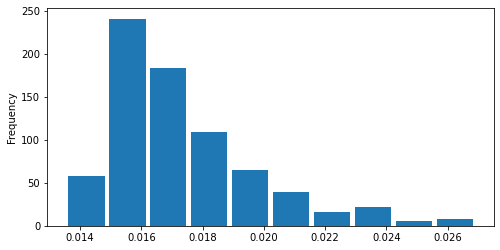

In [21]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
pd_params['min_valid_loss'].plot(kind='hist', rwidth=0.9, bins=10, density=True, ax=ax)
#ax.set(xlim=[0.004, 0.015], xlabel='Validation error', ylabel='Frequency rate')

In [22]:
optimal_params = pd_params[pd_params['min_valid_loss'] == pd_params['min_valid_loss'].min()]
enc_hid_dim = optimal_params['enc_hid_dim'].values[0]
dec_hid_dim = optimal_params['dec_hid_dim'].values[0]
drop_out = optimal_params['dropout'].values[0]

In [23]:
print('The optimal encoder hidden dim is %d'%enc_hid_dim)
print('The optimal decoder hidden dim is %d'%dec_hid_dim)
print('dropout is %.1f'%drop_out)

The optimal encoder hidden dim is 200
The optimal decoder hidden dim is 200
dropout is 0.4


<AxesSubplot:xlabel='dropout', ylabel='min_valid_loss'>

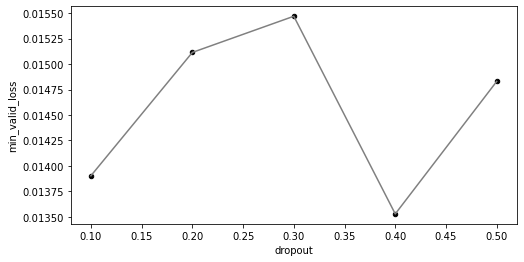

In [24]:
pd_params_1 = pd_params[(pd_params['enc_hid_dim'] == enc_hid_dim) & (pd_params['dec_hid_dim'] == dec_hid_dim)]
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
pd_params_1.plot(x='dropout', y='min_valid_loss', kind='scatter', ax=ax, color='black', legend=False)
pd_params_1.plot(x='dropout', y='min_valid_loss', kind='line', ax=ax, color='grey', legend=False)

<AxesSubplot:xlabel='dec_hid_dim', ylabel='min_valid_loss'>

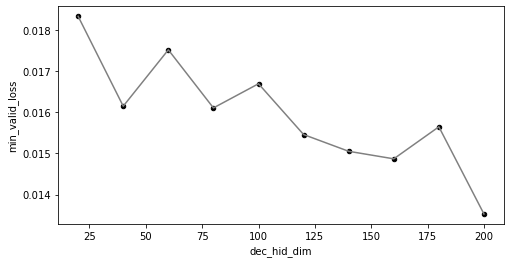

In [25]:
pd_params_1 = pd_params[(pd_params['enc_hid_dim'] == enc_hid_dim) & (pd_params['dropout'] == drop_out)]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
pd_params_1.plot(x='dec_hid_dim', y='min_valid_loss', kind='scatter', ax=ax, color='black', legend=False)
pd_params_1.plot(x='dec_hid_dim', y='min_valid_loss', kind='line', ax=ax, color='grey', legend=False)

<AxesSubplot:xlabel='enc_hid_dim', ylabel='min_valid_loss'>

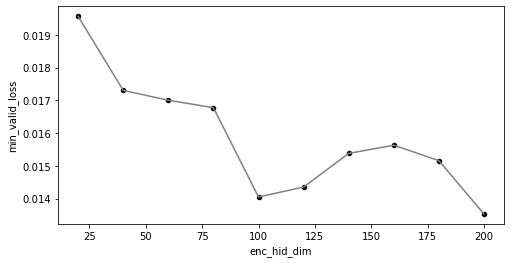

In [26]:
pd_params_1 = pd_params[(pd_params['dec_hid_dim'] == dec_hid_dim) & (pd_params['dropout'] == drop_out)]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
pd_params_1.plot(x='enc_hid_dim', y='min_valid_loss', kind='scatter', ax=ax, color='black', legend=False)
pd_params_1.plot(x='enc_hid_dim', y='min_valid_loss', kind='line', ax=ax, color='grey', legend=False)


<AxesSubplot:ylabel='Frequency'>

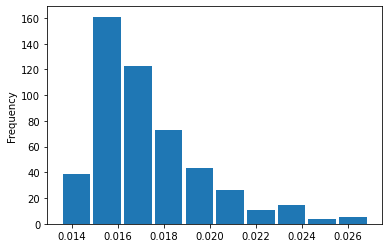

In [27]:
pd_params['min_valid_loss'].plot(kind='hist', rwidth=0.9, bins=10)

<AxesSubplot:xlabel='training_iteration'>

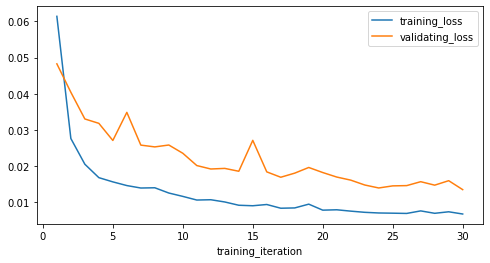

In [28]:
df_data_1 = df_data[(df_data['dropout'] == drop_out) & (df_data['enc_hid_dim'] == enc_hid_dim) & (df_data['dec_hid_dim'] == dec_hid_dim)]
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
df_data_1.plot(x='training_iteration' , y=['training_loss', 'validating_loss'], ax=ax, legend=True)
#df_data_1.plot(x='training_iteration', y=['training_loss', 'validating_loss'], kind='scatter', ax=ax, legend=False)
